Classify Text into Labels


In [1]:
from dotenv import load_dotenv
import os
load_dotenv()
import getpass
import os
from langchain_groq import ChatGroq
os.environ["GROQ_API_KEY"] = os.environ['groqe_api_key']
model = ChatGroq(model="llama3-8b-8192")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_API_KEY"] = os.environ["langchain_api_key"]


In [ ]:
from langchain_core.prompts import ChatPromptTemplate

from pydantic import BaseModel, Field

tagging_prompt = ChatPromptTemplate.from_template(
    """
Extract the desired information from the following passage.

Only extract the properties mentioned in the 'Classification' function.

Passage:
{input}
"""
)


class Classification(BaseModel):
    sentiment: str = Field(description="The sentiment of the text")
    aggressiveness: int = Field(
        description="How aggressive the text is on a scale from 1 to 10"
    )
    language: str = Field(description="The language the text is written in")

# model = ChatGroq(model="llama3-8b-8192")
# LLM


# LLM
llm = ChatGroq(temperature=0, model="llama3-8b-8192").with_structured_output(
    Classification
)

In [8]:
inp = "Estoy increiblemente contento de haberte conocido! Creo que seremos muy buenos amigos!"
prompt = tagging_prompt.invoke({"input": inp})
response = llm.invoke(prompt)

response

BadRequestError: Error code: 400 - {'error': {'message': "Failed to call a function. Please adjust your prompt. See 'failed_generation' for more details.", 'type': 'invalid_request_error', 'code': 'tool_use_failed', 'failed_generation': "The passage does not contain any information related to the 'Classification' function. The passage is a Spanish sentence expressing happiness and friendship."}}

In [9]:
class Classification(BaseModel):
    sentiment: str = Field(..., enum=["happy", "neutral", "sad"])
    aggressiveness: int = Field(
        ...,
        description="describes how aggressive the statement is, the higher the number the more aggressive",
        enum=[1, 2, 3, 4, 5],
    )
    language: str = Field(
        ..., enum=["spanish", "english", "french", "german", "italian"]
    )

In [11]:
tagging_prompt = ChatPromptTemplate.from_template(
    """
Extract the desired information from the following passage.

Only extract the properties mentioned in the 'Classification' function.

Passage:
{input}
"""
)

llm = ChatGroq(temperature=0, model="llama3-8b-8192").with_structured_output(
    Classification
)

In [12]:
inp = "Estoy increiblemente contento de haberte conocido! Creo que seremos muy buenos amigos!"
prompt = tagging_prompt.invoke({"input": inp})
llm.invoke(prompt)

BadRequestError: Error code: 400 - {'error': {'message': "Failed to call a function. Please adjust your prompt. See 'failed_generation' for more details.", 'type': 'invalid_request_error', 'code': 'tool_use_failed', 'failed_generation': "The passage does not contain any information related to the 'Classification' function. The passage is a sentence in Spanish, and it does not mention any properties or parameters related to the 'Classification' function."}}

In [13]:
inp = "Estoy muy enojado con vos! Te voy a dar tu merecido!"
prompt = tagging_prompt.invoke({"input": inp})
llm.invoke(prompt)


BadRequestError: Error code: 400 - {'error': {'message': "Failed to call a function. Please adjust your prompt. See 'failed_generation' for more details.", 'type': 'invalid_request_error', 'code': 'tool_use_failed', 'failed_generation': "The passage does not contain any information about the 'Classification' function. It appears to be a sentence in Spanish."}}

Structured outputs

For many applications, such as chatbots, models need to respond to users directly in natural language. However, there are scenarios where we need models to output in a structured format. For example, we might want to store the model output in a database and ensure that the output conforms to the database schema. This need motivates the concept of structured output, where models can be instructed to respond with a particular output structure

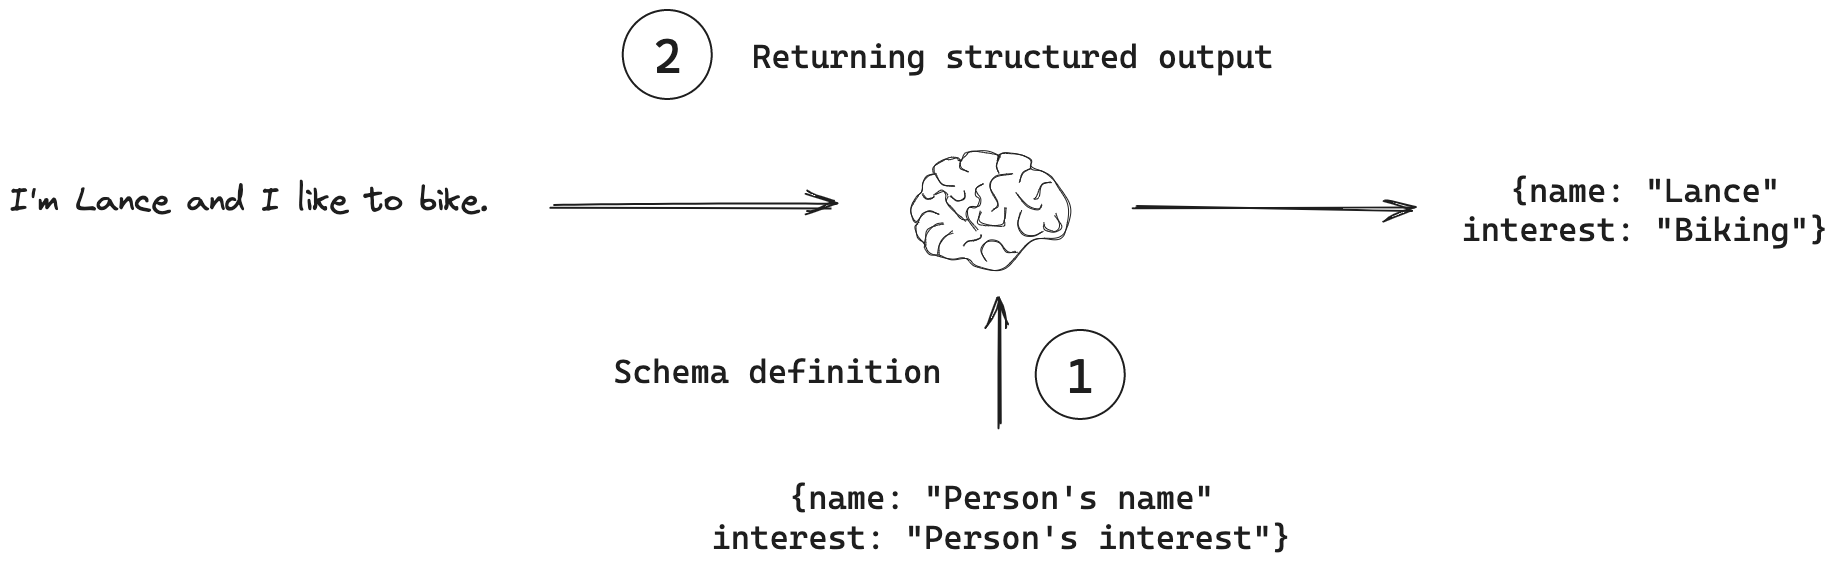

1) Schema definition: The output structure is represented as a schema, which can be defined in several ways. (2) Returning structured output: The model is given this schema, and is instructed to return output that conforms to it.

In [ ]:
# Define schema
schema = {"foo": "bar"}
# Bind schema to model
model_with_structure = model.with_structured_output(schema)
# Invoke the model to produce structured output that matches the schema
structured_output = model_with_structure.invoke(user_input)

In [ ]:
{
  "answer": "The answer to the user's question",
  "followup_question": "A followup question the user could ask"
}

In [ ]:
from pydantic import BaseModel, Field
class ResponseFormatter(BaseModel):
    """Always use this tool to structure your response to the user."""
    answer: str = Field(description="The answer to the user's question")
    followup_question: str = Field(description="A followup question the user could ask")


In [ ]:
from langchain_openai import ChatOpenAI
model = ChatOpenAI(model="gpt-4o", temperature=0)
# Bind responseformatter schema as a tool to the model
model_with_tools = model.bind_tools([ResponseFormatter])
# Invoke the model
ai_msg = model_with_tools.invoke("What is the powerhouse of the cell?")

In [ ]:
# Get the tool call arguments
ai_msg.tool_calls[0]["args"]
{'answer': "The powerhouse of the cell is the mitochondrion. Mitochondria are organelles that generate most of the cell's supply of adenosine triphosphate (ATP), which is used as a source of chemical energy.",
 'followup_question': 'What is the function of ATP in the cell?'}
# Parse the dictionary into a pydantic object
pydantic_object = ResponseFormatter.model_validate(ai_msg.tool_calls[0]["args"])

In [ ]:
from langchain_openai import ChatOpenAI
model = ChatOpenAI(model="gpt-4o", model_kwargs={ "response_format": { "type": "json_object" } })
ai_msg = model.invoke("Return a JSON object with key 'random_ints' and a value of 10 random ints in [0-99]")
ai_msg.content
'\n{\n  "random_ints": [23, 47, 89, 15, 34, 76, 58, 3, 62, 91]\n}'

In [ ]:
import json
json_object = json.loads(ai_msg.content)
{'random_ints': [23, 47, 89, 15, 34, 76, 58, 3, 62, 91]}

In [ ]:
# Bind the schema to the model
model_with_structure = model.with_structured_output(ResponseFormatter)
# Invoke the model
structured_output = model_with_structure.invoke("What is the powerhouse of the cell?")
# Get back the pydantic object
structured_output
ResponseFormatter(answer="The powerhouse of the cell is the mitochondrion. Mitochondria are organelles that generate most of the cell's supply of adenosine triphosphate (ATP), which is used as a source of chemical energy.", followup_question='What is the function of ATP in the cell?')

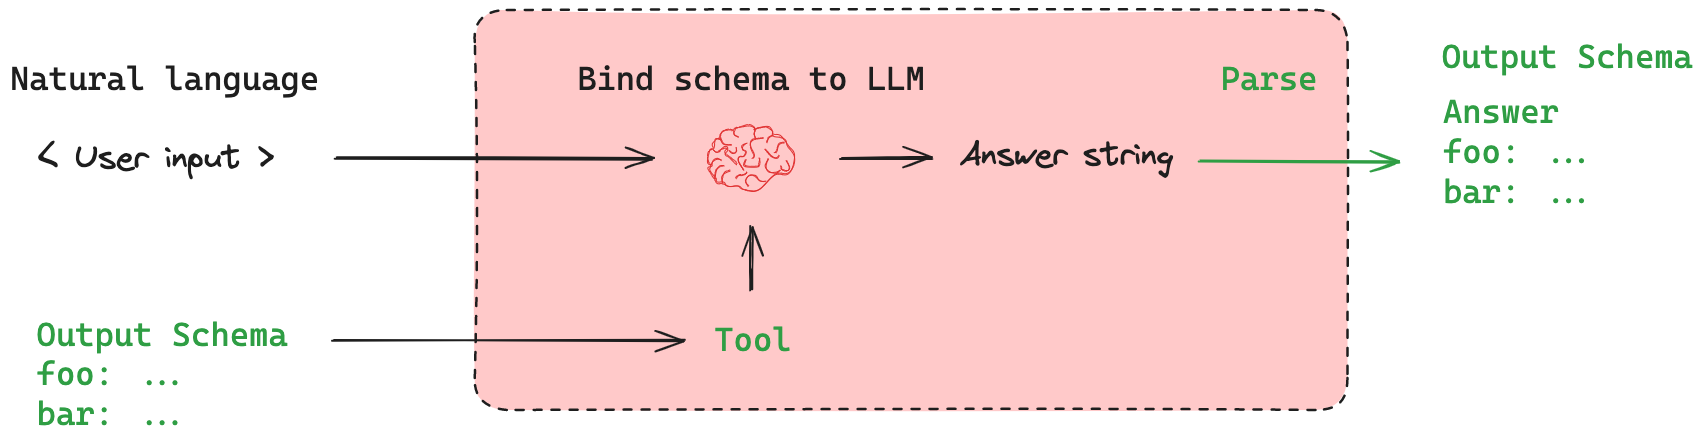

The Extractor

he Schema
First, we need to describe what information we want to extract from the text.

We'll use Pydantic to define an example schema to extract personal information.

In [14]:
from typing import Optional

from pydantic import BaseModel, Field


class Person(BaseModel):
    """Information about a person."""

    # ^ Doc-string for the entity Person.
    # This doc-string is sent to the LLM as the description of the schema Person,
    # and it can help to improve extraction results.

    # Note that:
    # 1. Each field is an `optional` -- this allows the model to decline to extract it!
    # 2. Each field has a `description` -- this description is used by the LLM.
    # Having a good description can help improve extraction results.
    name: Optional[str] = Field(default=None, description="The name of the person")
    hair_color: Optional[str] = Field(
        default=None, description="The color of the person's hair if known"
    )
    height_in_meters: Optional[str] = Field(
        default=None, description="Height measured in meters"
    )

In [15]:
from typing import Optional

from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from pydantic import BaseModel, Field

# Define a custom prompt to provide instructions and any additional context.
# 1) You can add examples into the prompt template to improve extraction quality
# 2) Introduce additional parameters to take context into account (e.g., include metadata
#    about the document from which the text was extracted.)
prompt_template = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are an expert extraction algorithm. "
            "Only extract relevant information from the text. "
            "If you do not know the value of an attribute asked to extract, "
            "return null for the attribute's value.",
        ),
        # Please see the how-to about improving performance with
        # reference examples.
        # MessagesPlaceholder('examples'),
        ("human", "{text}"),
    ]
)

In [16]:


llm = ChatGroq(model="llama3-8b-8192")

In [17]:
structured_llm = llm.with_structured_output(schema=Person)

In [18]:
text = "Alan Smith is 6 feet tall and has blond hair."
prompt = prompt_template.invoke({"text": text})
structured_llm.invoke(prompt)

Person(name='Alan Smith', hair_color='blond', height_in_meters='1.83')

Multiple Entities

In most cases, you should be extracting a list of entities rather than a single entity.

This can be easily achieved using pydantic by nesting models inside one another.

In [19]:
from typing import List, Optional

from pydantic import BaseModel, Field


class Person(BaseModel):
    """Information about a person."""

    # ^ Doc-string for the entity Person.
    # This doc-string is sent to the LLM as the description of the schema Person,
    # and it can help to improve extraction results.

    # Note that:
    # 1. Each field is an `optional` -- this allows the model to decline to extract it!
    # 2. Each field has a `description` -- this description is used by the LLM.
    # Having a good description can help improve extraction results.
    name: Optional[str] = Field(default=None, description="The name of the person")
    hair_color: Optional[str] = Field(
        default=None, description="The color of the person's hair if known"
    )
    height_in_meters: Optional[str] = Field(
        default=None, description="Height measured in meters"
    )


class Data(BaseModel):
    """Extracted data about people."""

    # Creates a model so that we can extract multiple entities.
    people: List[Person]

In [20]:
structured_llm = llm.with_structured_output(schema=Data)
text = "My name is Jeff, my hair is black and i am 6 feet tall. Anna has the same color hair as me."
prompt = prompt_template.invoke({"text": text})
structured_llm.invoke(prompt)

BadRequestError: Error code: 400 - {'error': {'message': "Failed to call a function. Please adjust your prompt. See 'failed_generation' for more details.", 'type': 'invalid_request_error', 'code': 'tool_use_failed', 'failed_generation': '<tool-use>\n{\n\t"tool_calls": [\n\t\t{\n\t\t\t"id": "pending",\n\t\t\t"type": "function",\n\t\t\t"function": {\n\t\t\t\t"name": "Data"\n\t\t\t},\n\t\t\t"parameters": {\n\t\t\t\t"people": [\n\t\t\t\t\t{\n\t\t\t\t\t\t"hair_color": "black",\n\t\t\t\t\t\t"height_in_meters": 1.83,\n\t\t\t\t\t\t"name": "Jeff"\n\t\t\t\t\t},\n\t\t\t\t\t{\n\t\t\t\t\t\t"hair_color": "black",\n\t\t\t\t\t\t"height_in_meters": null,\n\t\t\t\t\t\t"name": "Anna"\n\t\t\t\t\t}\n\t\t\t\t]\n\t\t\t}\n\t\t}\n\t]\n}\n</tool-use>'}}

In [21]:
messages = [
    {"role": "user", "content": "2 🦜 2"},
    {"role": "assistant", "content": "4"},
    {"role": "user", "content": "2 🦜 3"},
    {"role": "assistant", "content": "5"},
    {"role": "user", "content": "3 🦜 4"},
]

response = llm.invoke(messages)
print(response.content)

7


In [23]:
from langchain_core.utils.function_calling import tool_example_to_messages

examples = [
    (
        "The ocean is vast and blue. It's more than 20,000 feet deep.",
        Data(people=[]),
    ),
    (
        "Fiona traveled far from France to Spain.",
        Data(people=[Person(name="Fiona", height_in_meters=None, hair_color=None)]),
    ),
]


messages = []

for txt, tool_call in examples:
    if tool_call.people:
        # This final message is optional for some providers
        ai_response = "Detected people."
    else:
        ai_response = "Detected no people."
    messages.extend(tool_example_to_messages(txt, [tool_call], ai_response=ai_response))

C:\Users\lenovo\AppData\Local\Temp\ipykernel_7252\81328896.py:23: LangChainBetaWarning: The function `tool_example_to_messages` is in beta. It is actively being worked on, so the API may change.
  messages.extend(tool_example_to_messages(txt, [tool_call], ai_response=ai_response))


In [24]:
for message in messages:
    message.pretty_print()

================================ Human Message =================================

The ocean is vast and blue. It's more than 20,000 feet deep.
================================== Ai Message ==================================
Tool Calls:
  Data (1746936f-61f8-4b7a-a760-840017b23b07)
 Call ID: 1746936f-61f8-4b7a-a760-840017b23b07
  Args:
    people: []
================================= Tool Message =================================

You have correctly called this tool.
================================== Ai Message ==================================

Detected no people.
================================ Human Message =================================

Fiona traveled far from France to Spain.
================================== Ai Message ==================================
Tool Calls:
  Data (7baa2fc9-f3c6-488d-a763-f896b30331e2)
 Call ID: 7baa2fc9-f3c6-488d-a763-f896b30331e2
  Args:
    people: [{'name': 'Fiona', 'hair_color': None, 'height_in_meters': None}]
================================

In [25]:
message_no_extraction = {
    "role": "user",
    "content": "The solar system is large, but earth has only 1 moon.",
}

structured_llm = llm.with_structured_output(schema=Data)
structured_llm.invoke([message_no_extraction])

Data(people=[Person(name='John', hair_color='Brown', height_in_meters='1.75')])

In [26]:
structured_llm.invoke(messages + [message_no_extraction])

Data(people=[])